In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU')))

2.10.0
1


In [3]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()
#x_train = x_train.reshape(-1, 28, 28, 1)
#x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170498071/170498071 [==============================] - 20s 0us/step


In [9]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),

        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn1"),
        keras.layers.Conv2D(32, (3, 3),name="conv2", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn2"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3),name="conv3", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn3"),
        keras.layers.Conv2D(64, (3, 3),name="conv4", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn4"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(128, (3, 3),name="conv5", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn5"),
        keras.layers.Conv2D(128, (3, 3),name="conv6", activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.BatchNormalization(name="bn6"),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp3"),
        keras.layers.Dropout(0.2),

        keras.layers.Flatten(name = "flatten"),

        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu', kernel_initializer='he_uniform'),
        keras.layers.BatchNormalization(name="bn7"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, name="dense3", activation='softmax')
    ],
    name="modelo-0.0",
)

for layer in model.trainable_variables:
    #print(layer.name)
    if 'bias' in layer.name:
        new_bias = tf.cast(tf.where(tf.abs(layer) >= 0, 0.1, 0.1), tf.float32)
        layer.assign(new_bias)

model.summary()

Model: "modelo-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (64, 32, 32, 32)          896       
                                                                 
 bn1 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 conv2 (Conv2D)              (64, 32, 32, 32)          9248      
                                                                 
 bn2 (BatchNormalization)    (64, 32, 32, 32)          128       
                                                                 
 mp1 (MaxPooling2D)          (64, 16, 16, 32)          0         
                                                                 
 dropout_4 (Dropout)         (64, 16, 16, 32)          0         
                                                                 
 conv3 (Conv2D)              (64, 16, 16, 64)          1

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class QuantizationTrainer:
    def __init__(self, model, train_ds, test_ds, loss_fn,
                 train_accuracy, test_accuracy,
                 epochs=40, n_bits=8, learning_rate=0.05, momentum =0.9):

        self.model = model
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.loss_fn = loss_fn
        self.train_accuracy = train_accuracy
        self.test_accuracy = test_accuracy

        # hyperparameters
        self.epochs = epochs
        self.n_bits = n_bits
        self.learning_rate = learning_rate
        self.momentum = 0.9
        self.v = [0]*len(model.trainable_weights)

        # logs
        self.model_sparsity = []
        self.model_train_loss = []
        self.model_train_acc = []
        self.model_test_loss = []
        self.model_test_acc = []

    def quantize_weights(self):
        """Quantiza pesos do modelo."""
        if self.n_bits <= 0:
            return

        for i, layer_weights in enumerate(self.model.trainable_variables):
            if 'bn' in layer_weights.name:
                continue
            qk_line = (tf.reduce_max(tf.math.abs(layer_weights))) / (2 ** (self.n_bits - 1) - 1)
            qk_line = tf.maximum(qk_line, 1e-9)
            ck = tf.math.round(layer_weights / qk_line) * qk_line
            layer_weights.assign(ck)
            #if qk_line != 0.0:


    def train(self):
      np.set_printoptions(threshold=np.inf)

      for epoch in range(self.epochs):
          acc_epoch_mean, loss_epoch_mean = [], []
          acct_epoch_mean, losst_epoch_mean = [], []

          for step, (x_batch_train, y_batch_train) in enumerate(self.train_ds):
              
              # Cálculo da loss e do gradiente
              with tf.GradientTape() as tape:
                  pred = self.model(x_batch_train, training=True)
                  loss = self.loss_fn(y_batch_train, pred)

              grads = tape.gradient(loss, self.model.trainable_weights)

              # Atualização com momentum
              for i, w in enumerate(self.model.trainable_variables):
                  if step == 0 and epoch == 0:
                      self.v[i] = grads[i] * 0.0
                  grads[i] = tf.clip_by_value(grads[i], -1.0, 1.0) * self.learning_rate
                  self.v[i] = self.momentum * self.v[i] - grads[i]
                  w.assign_add(self.v[i])  # w(n+1) = w(n) + Δw

              # Forward com pesos quantizados (não altera pesos originais)
              if self.n_bits > 0:
                  self.quantize_weights()

              # Métricas
              predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
              yy = tf.argmax(y_batch_train, axis=1, output_type=tf.int32)
              acc = self.train_accuracy(tf.reshape(y_batch_train, [-1]), predictions)

              acc_epoch_mean.append(acc)
              loss_epoch_mean.append(loss)

              self.train_accuracy.update_state(yy, predictions)

          # Quantização final opcional (para avaliação)
          if self.n_bits > 0:
              self.quantize_weights()

          # Teste
          for step, (x_batch_test, y_batch_test) in enumerate(self.test_ds):
              test_pred = self.model(x_batch_test, training=False)
              test_loss = self.loss_fn(y_batch_test, test_pred)
              test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
              test_acc = self.test_accuracy(tf.reshape(y_batch_test, [-1]), test_prediction)

              acct_epoch_mean.append(test_acc)
              losst_epoch_mean.append(test_loss)

          # Logs
          self.model_test_acc.append(np.mean(acct_epoch_mean) * 100)
          self.model_test_loss.append(np.mean(losst_epoch_mean) * 100)
          self.model_train_acc.append(np.mean(acc_epoch_mean))
          self.model_train_loss.append(np.mean(loss_epoch_mean))

          print(f"Epoch {epoch+1}/{self.epochs} \t "
                f"Loss={float(loss):.3f} \t "
                f"Train Acc={float(acc)*100:.2f}% \t "
                f"Test Acc={float(test_acc)*100:.2f}%")


In [11]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
train_accuracy = tf.keras.metrics.Accuracy()
test_accuracy = tf.keras.metrics.Accuracy()

In [12]:
trainer = QuantizationTrainer(model, train_ds, test_ds, loss_fn, train_accuracy, test_accuracy, epochs=5)
trainer.train()

Epoch 1/5 	 Loss=1.555 	 Train Acc=22.54% 	 Test Acc=39.48%
Epoch 2/5 	 Loss=1.676 	 Train Acc=24.44% 	 Test Acc=38.60%
Epoch 3/5 	 Loss=1.408 	 Train Acc=25.58% 	 Test Acc=42.02%
Epoch 4/5 	 Loss=1.396 	 Train Acc=26.30% 	 Test Acc=43.35%
Epoch 5/5 	 Loss=0.907 	 Train Acc=26.81% 	 Test Acc=44.00%


conv1/kernel:0
conv2/kernel:0
conv3/kernel:0


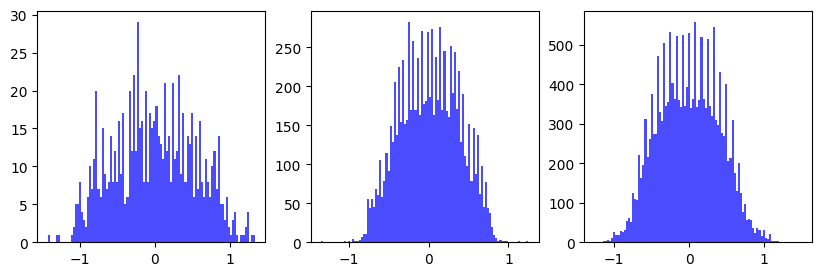

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
i = 0
for l in trainer.model.trainable_weights:
    if "kernel" in l.name:
        print(l.name)
        f_w = tf.reshape(l, [-1])
        axes[i].hist(f_w, bins=100, color="blue", alpha=0.7)
        i+=1
        if i == 3:
            break
plt.show()